In [26]:
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn import preprocessing
import torch
import torch.nn as nn
import math
import random
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
audio_data, sr = librosa.load('data\\wavfiles\\97957-2.wav')

In [3]:
import random
import statistics

(66150,)


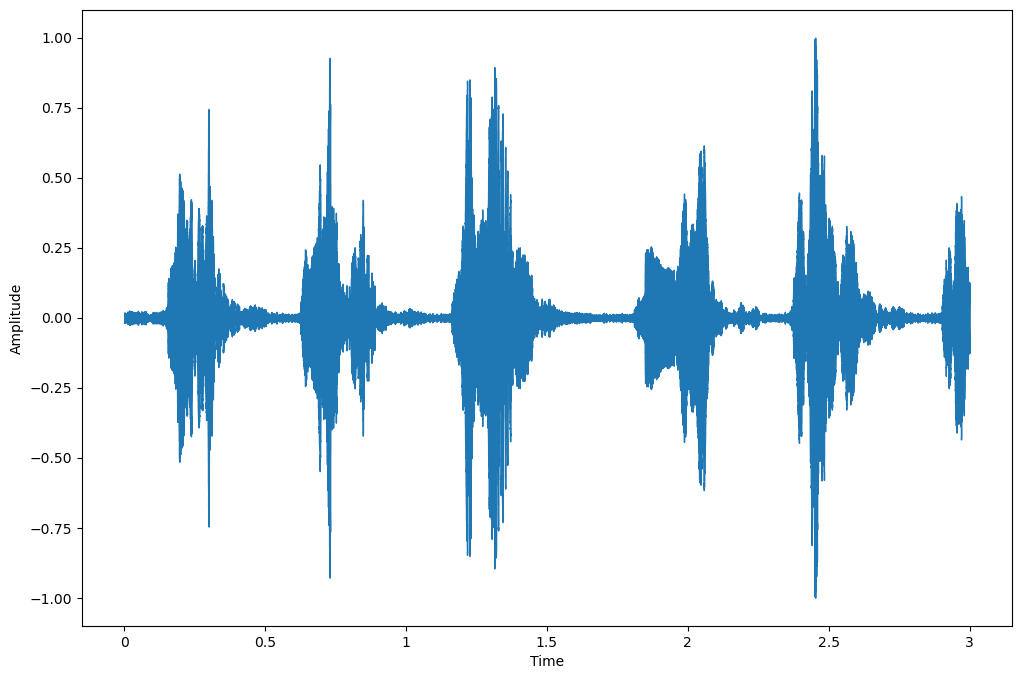

In [4]:

print(np.shape(audio_data))
plt.figure(figsize=(12, 8))
librosa.display.waveshow(audio_data, sr=sr)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [142]:
# Creating labels
bird_df = pd.read_csv("data\\bird_songs_metadata.csv", usecols=['filename','species'])
bird_df["filename"] = "data\\wavfiles\\"+bird_df["filename"]
bird_df.head()

,species,filename
0,bewickii,data\wavfiles\557838-0.wav
1,bewickii,data\wavfiles\557838-1.wav
2,bewickii,data\wavfiles\557838-4.wav
3,bewickii,data\wavfiles\557838-5.wav
4,bewickii,data\wavfiles\557838-6.wav


In [143]:
def convert_wav_to_list(path):
    y,_ = librosa.load(path)
    return y.astype(float)

In [144]:
bird_df["audio"] = [convert_wav_to_list(file) for file in bird_df["filename"]] #2.5 mins

In [145]:
bird_df.head()
bird_df.dtypes

species     object
filename    object
audio       object
dtype: object

In [146]:
label_encoder = LabelEncoder()
bird_df["species"] = label_encoder.fit_transform(bird_df["species"])

In [147]:
bird_df["species"] = bird_df["species"].to_numpy()

In [148]:
bird_df.head()
type(bird_df["audio"])

pandas.core.series.Series

In [176]:
normalizer = preprocessing.Normalizer()
temp_audio = normalizer.fit_transform(bird_df["audio"].to_list())
bird_df["audio"] = torch.FloatTensor(temp_audio)

In [177]:
X_train, X_test, y_train, y_test = train_test_split(bird_df["audio"], bird_df["species"], random_state=42)

In [178]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        audio = self.data[idx]
        return audio, label

In [179]:
train_dataset = CustomDataset(X_train, y_train)
audio, label = train_dataset[0]
label
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=False) # KeyError when batch_size > 8

In [180]:
#Creating our LSTM class
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, classes, batch_size=8):
        super(Net, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.classes = classes
        self.batch_size = batch_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.linear = nn.Linear(hidden_size, classes)
        
    def forward(self, x):
        lstm_out = self.lstm(x)
        out = self.linear(lstm_out) # 3
        return out

In [181]:
#Training and Testing Model

net = Net(66150, 128, 2, 5)
crit = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(net.parameters(), lr=0.005)

losses = []

for i in range(5):
    print("starting epoch",i)
    epoch_loss = []
    for audio, label in train_dataloader:
        # label = torch.FloatTensor(label)
        out = net(audio)
        loss = crit(out, label)
        optim.zero_grad()
        loss.backward()
        optim.step()
        epoch_loss.append(loss)
print(losses)

starting epoch 0


ValueError: LSTM: Expected input to be 2D or 3D, got 1D instead

In [74]:
accuracy

[0.222, 0.248, 0.287, 0.288, 0.304]